In [1]:
%config Completer.use_jedi = False

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [3]:
df = pd.read_csv("data/h1weekly.csv")

In [27]:
df.head()

,Date,IsCanceled
0,2015-06-21,41
1,2015-06-28,48
2,2015-07-05,87
3,2015-07-12,74
4,2015-07-19,101


(array([ 7., 18., 15., 20., 16., 17., 11.,  5.,  4.,  2.]),
 array([ 14. ,  34.8,  55.6,  76.4,  97.2, 118. , 138.8, 159.6, 180.4,
        201.2, 222. ]),
 <BarContainer object of 10 artists>)

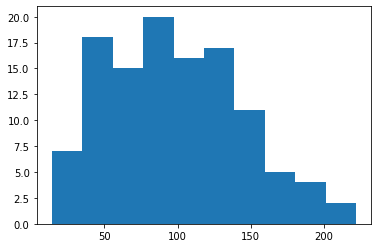

In [28]:
plt.hist(df["IsCanceled"])

In [7]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=df["IsCanceled"])
    
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [9]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


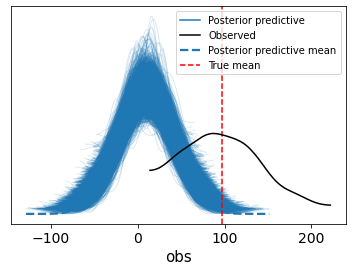

In [14]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(df["IsCanceled"].mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

In [29]:
mu_prior=120
sigma_prior=10

with pm.Model() as model:
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    sd = pm.HalfNormal("sd", sigma=sigma_prior)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=df["IsCanceled"])
    
    idata = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


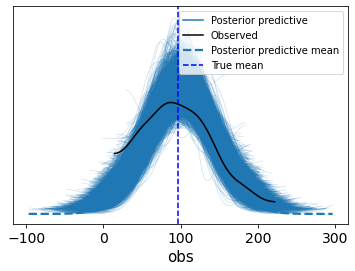

In [30]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(df["IsCanceled"].mean(), ls="--", color="b", label="True mean")
ax.legend(fontsize=10);

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

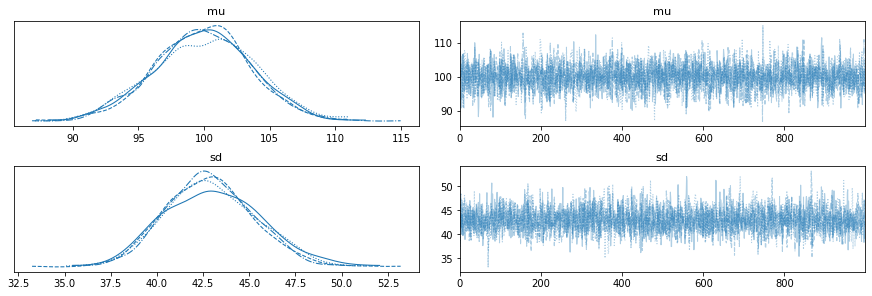

In [31]:
az.plot_trace(idata)

In [32]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,99.932,3.755,92.764,106.818,0.066,0.047,3204.0,2670.0,1.0
sd,42.941,2.485,38.489,47.563,0.044,0.031,3211.0,2795.0,1.0


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sd'}>], dtype=object)

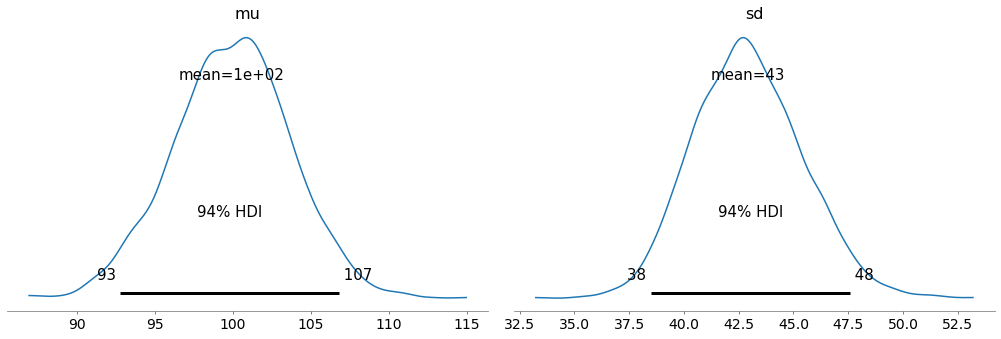

In [33]:
az.plot_posterior(idata)

In [18]:
x = df["IsCanceled"]
y = x > 0

with pm.Model() as model:
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)
    
    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli("obs", p=logistic, observed=y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
with model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [22]:
post_pred["obs"].mean(axis=0)

array([0.28775, 0.51375, 0.675  ])

In [34]:
ma = df["IsCanceled"].rolling(3).mean()

In [35]:
ma

0             NaN
1             NaN
2       58.666667
3       69.666667
4       87.333333
          ...    
110    160.000000
111    156.666667
112    165.000000
113    155.000000
114    141.666667
Name: IsCanceled, Length: 115, dtype: float64

In [47]:
ts = ma[3-1:]

In [48]:
ts

2       58.666667
3       69.666667
4       87.333333
5       81.000000
6       88.333333
          ...    
110    160.000000
111    156.666667
112    165.000000
113    155.000000
114    141.666667
Name: IsCanceled, Length: 113, dtype: float64

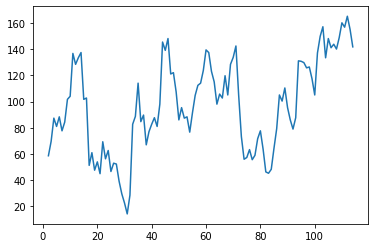

In [45]:
plt.plot(ts)

/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not usin

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.878,0.041,0.801,0.955,0.001,0.0,4790.0,2991.0,1.0
tau,0.000,0.000,0.000,0.001,0.000,0.0,4847.0,3832.0,1.0


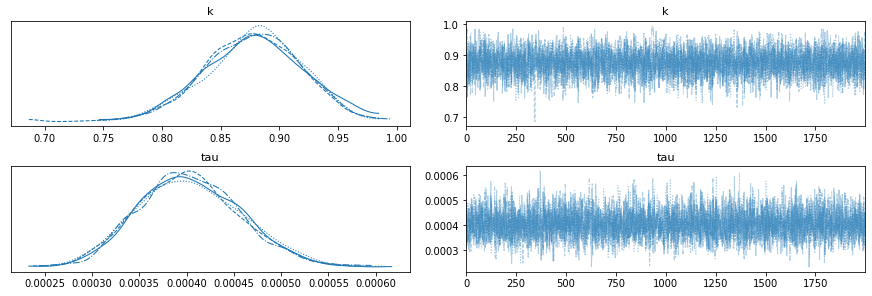

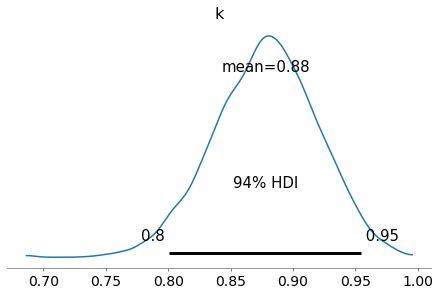

In [54]:
with pm.Model() as model:
    k = pm.Uniform('k', -1, 1)
    tau = pm.Gamma('tau', mu=1, sd=1)
    obs = pm.AR1('observed', k=k, tau_e=tau, observed=df["IsCanceled"])
    trace = pm.sample(2000)
az.plot_trace(trace)
az.plot_posterior(trace, 'k')
az.summary(trace)

/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will ret

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.983,0.010,0.965,1.000,0.0,0.0,3560.0,2605.0,1.0
tau,0.004,0.001,0.003,0.005,0.0,0.0,3437.0,3794.0,1.0


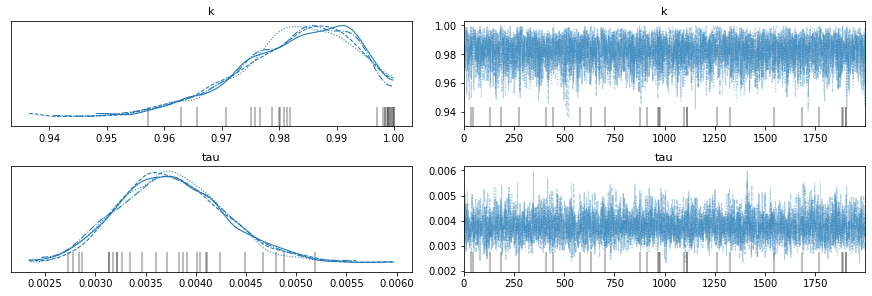

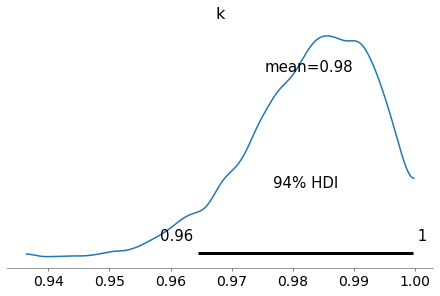

In [56]:
with pm.Model() as model:
    k = pm.Uniform('k', -1, 1)
    tau = pm.Gamma('tau', mu=1, sd=1)
    obs = pm.AR1('observed', k=k, tau_e=tau, observed=ts)
    trace = pm.sample(2000)
az.plot_trace(trace)
az.plot_posterior(trace, 'k')
az.summary(trace)

In [67]:
with pm.Model() as model:
    cancels = pm.Data("cancellations", df["IsCanceled"], dims="Date", export_index_as_coords=True)
    nu = pm.Exponential("nu", 1/10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="Date")
    volatility = pm.Deterministic("volatility", pm.math.exp(-2 * s)**0.5, dims="Date")
    r = pm.StudentT("r", nu=nu, sigma=volatility, observed=cancels, dims="Date")

In [68]:
model.RV_dims

{'cancellations': ('Date',),
 's': ('Date',),
 'volatility': ('Date',),
 'r': ('Date',)}

In [69]:
with model:
    trace = pm.sample(1000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 126 seconds.


0, dim: Date, 115 =? 115


The acceptance probability does not match the target. It is 0.689068529365748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9673933138977386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6685457152808292, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/z001hqv/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0, dim: Date, 115 =? 115
0, dim: Date, 115 =? 115


array([[<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

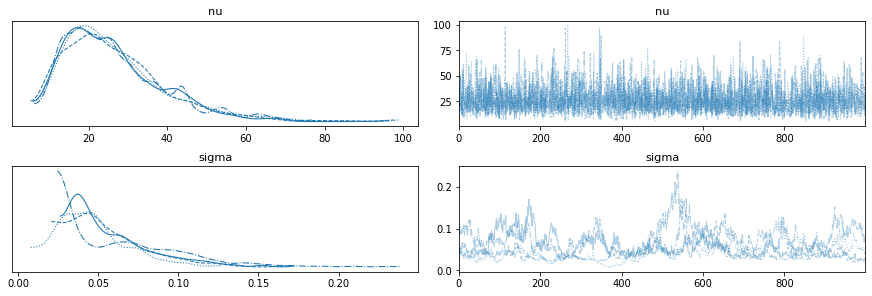

In [71]:
az.plot_trace(trace, var_names=['nu', 'sigma'])

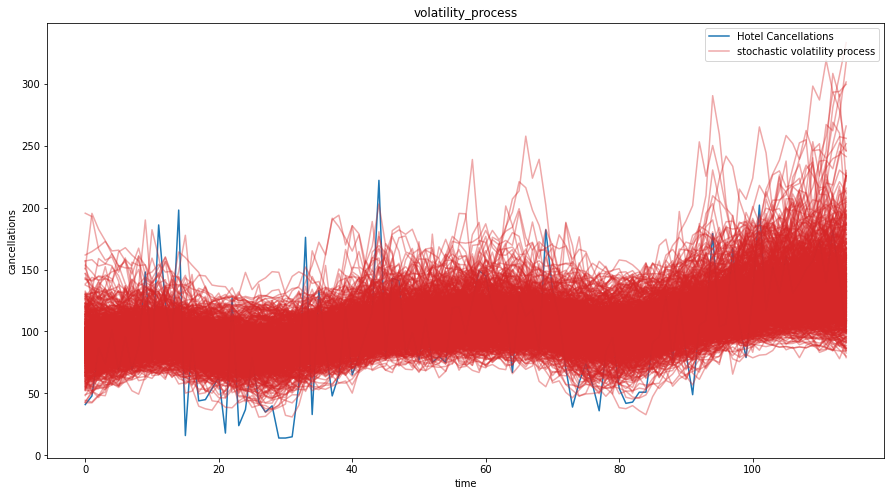

In [72]:
fig, ax = plt.subplots(figsize=(15, 8))
df.plot(ax=ax)
ax.plot(df.index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.4)
ax.set(title="volatility_process", xlabel="time", ylabel="cancellations")
ax.legend(["Hotel Cancellations", "stochastic volatility process"], loc="upper right");

In [73]:
df.index

RangeIndex(start=0, stop=115, step=1)

In [75]:
pm.sample_posterior_predictive(trace, model=model)

{'r': array([[ -40.69050087,   63.90074455, -183.98359172, ...,   21.53772627,
         -211.70940902,  219.15117218],
        [  57.18046099,  183.48258811,    7.76669404, ...,    9.09372346,
          -75.91187228,   74.25668655],
        [ -30.47997721,  108.77616763,  120.66384673, ...,  127.1458499 ,
          208.08689817,    4.7873735 ],
        ...,
        [  59.98359698,  122.77305675,  -36.1524305 , ...,   34.53068402,
          -79.81531319,  -69.58903121],
        [ 407.26684468,   99.32813858,  -14.70749852, ...,  161.13863532,
         -107.27373935,   43.34780432],
        [ -23.12076083,  -63.91216375,  127.39182655, ...,  247.22296696,
         -138.04340799, -222.82084721]])}